<a href="https://colab.research.google.com/github/kavya006/100DaysOfCode/blob/main/EmailClassifier_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf 
print(tf.__version__)

2.5.0


In [11]:
def setup_kaggle():
  from google.colab import files

  uploaded = files.upload()

  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    
  # Then move kaggle.json into the folder where the API expects to find it.
  !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

setup_kaggle()

In [13]:
!kaggle datasets download -d uciml/sms-spam-collection-dataset

!unzip sms-spam-collection-dataset.zip

sms-spam-collection-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  sms-spam-collection-dataset.zip
  inflating: spam.csv                


### Email Classifier 

1. Following the tutorial: https://medium.com/analytics-vidhya/spam-classification-with-tensorflow-keras-7e9fb8ace263

Follow Up: 
Planning to do the same with multiple other models using Tensorflow.
1. Linear Regression
2. Logistic Regression
3. KNN
4. SVM
5. Naive Bayes 
6. Deep Networks (RNN, LSTM)
7. Reinforcement Learning 
8. PySpark

#### Import the necessary libraries

In [14]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import nltk 
import pandas as pd 
%matplotlib inline

In [24]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')
print(df.head(10) )
df.info()

     v1  ... Unnamed: 4
0   ham  ...        NaN
1   ham  ...        NaN
2  spam  ...        NaN
3   ham  ...        NaN
4   ham  ...        NaN
5  spam  ...        NaN
6   ham  ...        NaN
7   ham  ...        NaN
8  spam  ...        NaN
9  spam  ...        NaN

[10 rows x 5 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [25]:
df = df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])

In [26]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [27]:
df['Spam'] = pd.get_dummies(df['v1'], drop_first=True)
df = df.drop(columns=['v1'])
df.head()

,v2,Spam
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


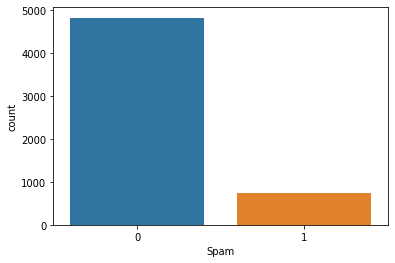

In [28]:
sns.countplot(x='Spam', data=df)

In [30]:
import re 
import string 
from string import punctuation 
nltk.download('stopwords')
from nltk.corpus import stopwords 

def text_processing(message): 
  Stopwords = stopwords.words('english')
  no_punctuations = [char for char in message if char not in punctuation]
  no_punctuations = ''.join(no_punctuations)
  no_stopwords = [word for word in no_punctuations.split() if word.lower() not in Stopwords]
  no_stopwords = ' '.join(no_stopwords)
  return no_stopwords

df['text'] = df['v2'].apply(text_processing)
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,v2,Spam,text
0,"Go until jurong point, crazy.. Available only ...",0,Go jurong point crazy Available bugis n great ...
1,Ok lar... Joking wif u oni...,0,Ok lar Joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,Free entry 2 wkly comp win FA Cup final tkts 2...
3,U dun say so early hor... U c already then say...,0,U dun say early hor U c already say
4,"Nah I don't think he goes to usf, he lives aro...",0,Nah dont think goes usf lives around though


In [48]:
from sklearn.model_selection import train_test_split
X = df['text'] 
y = df['Spam']

In [53]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

prep = Pipeline(
    [
      ('count_vectorizer', CountVectorizer()),
      ('frequency_encoder', TfidfTransformer())
    ]
)

X_train = prep.fit_transform(X_train).toarray()
X_test = prep.transform(X_test).toarray()

In [56]:
import tensorflow as tf 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Activation, Dropout
from sklearn.metrics import classification_report, confusion_matrix

def build_model_1():
  model = Sequential(
      [
        Dense(units=8270, activation='relu'),
        Dropout(0.5),
        Dense(units=4000, activation='relu'), 
        Dropout(0.5),
        Dense(units=1000, activation='relu'),
        Dropout(0.5),
        Dense(units=400, activation='relu'),
        Dropout(0.5),
        Dense(units=1, activation='sigmoid')
      ]
  )

  model.compile(loss='binary_crossentropy', optimizer='adam')
  return model 

from tensorflow.keras.callbacks import EarlyStopping 
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

model_1 = build_model_1()
model_1.fit(X_train, y_train, 
            epochs=40, validation_data=(X_test, y_test),
            verbose=1, callbacks=[early_stop])

predictions = np.argmax(model_1.predict(X_test), axis=-1)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

Epoch 1/40
140/140 [==============================] - 109s 767ms/step - loss: 0.1892 - val_loss: 0.0801
Epoch 2/40
140/140 [==============================] - 108s 770ms/step - loss: 0.0338 - val_loss: 0.1184
Epoch 3/40
140/140 [==============================] - 107s 765ms/step - loss: 0.0108 - val_loss: 0.1606
Epoch 4/40
140/140 [==============================] - 107s 765ms/step - loss: 0.0017 - val_loss: 0.1608
Epoch 5/40
140/140 [==============================] - 107s 764ms/step - loss: 0.0027 - val_loss: 0.2115
Epoch 6/40
140/140 [==============================] - 107s 765ms/step - loss: 2.1564e-05 - val_loss: 0.2747
Epoch 7/40
140/140 [==============================] - 107s 766ms/step - loss: 2.2005e-04 - val_loss: 0.3888
Epoch 8/40
140/140 [==============================] - 107s 764ms/step - loss: 3.4350e-07 - val_loss: 0.3940
Epoch 9/40
140/140 [==============================] - 107s 764ms/step - loss: 3.3897e-07 - val_loss: 0.3952
Epoch 10/40
140/140 [===========================

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[964   1]
 [ 20 130]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.99      0.87      0.93       150

    accuracy                           0.98      1115
   macro avg       0.99      0.93      0.96      1115
weighted avg       0.98      0.98      0.98      1115



array([0, 0, 0, ..., 0, 0, 0])